# GCC's ssc-cdi : tomography pipeline for Cateretê v0.1
 
- #### Questions? E-mail gcc@lnls.br
- #### Documentation about the ssc-cdi package: https://gcc.lnls.br/wiki/

## Imports

In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import json
import sscCdi
import sscRaft

print(f'sscCdi version: {sscCdi.__version__}')
print(f'sscRaft version: {sscRaft.__version__}')

sscCdi version: 0.6.21
sscRaft version: 2.2.0


## Load dictionary

In [2]:
dic = {}

In [3]:
# dic = json.load(open('/ibira/lnls/beamlines/caterete/apps/gcc-jupyter/inputs/CAT_tomo_inputs.json'))
# dic['processing_steps'] = {}
# dic['processing_steps']['read'] = True
# dic['processing_steps']['sort'] = True
# dic['processing_steps']['crop'] = True
# dic['processing_steps']['equalize2D'] = True
# dic['processing_steps']['unwrap'] = True
# dic['processing_steps']['alignment'] = True
# dic['processing_steps']['tomography'] = True
# dic['processing_steps']['equalize3D'] = True
# dic

# Run at Cluster

In [4]:
# server = sscInstall.connect_server()  

In [5]:
# json_filepath_path = sscCdi.cat_ptycho_processing.save_input_dictionary(dic)
# sscCdi.run_at_cluster(server,json_filepath_path,queue='cat',gpus=dic["GPUs"],cpus=dic["CPUs"],jobName='job',script_path = "/ibira/lnls/beamlines/caterete/apps/gcc-jupyter/ssc-cdi-0.5.1/bin/caterete_tomo.py",slurm_path = '/ibira/lnls/beamlines/caterete/apps/gcc-jupyter/inputs/')

# Run Locally

## Load data

In [6]:
dic["recon_method"]  = "ptycho" # ptycho or pwcdi
dic["contrast_type"] = "complex" # phase or magnitude
dic["sinogram_path"] = "/ibira/lnls/beamlines/caterete/apps/gcc-jupyter/00000000/proc/recons/glass_sphere/2023-05-16-15h38m_glass_sphere.hdf5"

In [7]:
dic = sscCdi.define_paths(dic)

In [9]:
obj, angles = sscCdi.read_data(dic)
print(f"Object shape = {obj.shape} \t Number of angles: {angles.shape}")

Object shape = (214, 3479, 3479) 	 Number of angles: (214, 2)


(100, 579, 579)
0
10
20
30
40
50
60
70
80
90


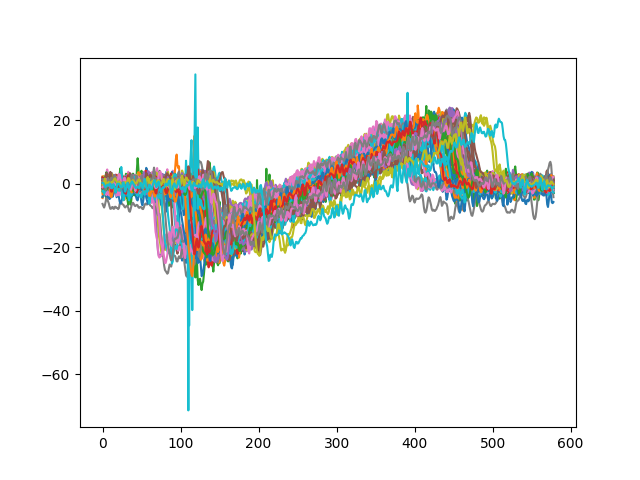

In [17]:
complex_obj = obj[:,1500:-1400,1400:-1500][0:100]
phase = np.angle(complex_obj)
print(phase.shape)
from skimage.restoration import unwrap_phase

# plt.figure()
# for i in range(complex_obj.shape[0]):
#     if i%50==0: print(i)
#     frame = phase[i]
#     # frame = -unwrap_phase(frame)

#     vmd = np.sum(frame,axis=1)

#     # plt.imshow(frame,cmap='gray',vmax=1) 
#     plt.plot(vmd)
    
    
plt.figure()
for i in range(complex_obj.shape[0]):
    if i%10==0: print(i)
   
    frame = complex_obj[i]

    gradient = np.gradient(frame)
    phase_gradient_y = np.imag( frame.conj() * gradient[0] / np.abs(frame)**2  )
    phase_gradient_y = np.sum(phase_gradient_y,axis=1)
    vmd = phase_gradient_y

    # vmd = np.sum(frame,axis=1)
    # vmd = vmd - phase_gradient_y
    
    # plt.imshow(frame,cmap='gray',vmax=1) 
    plt.plot(vmd)
    
        


(579,)


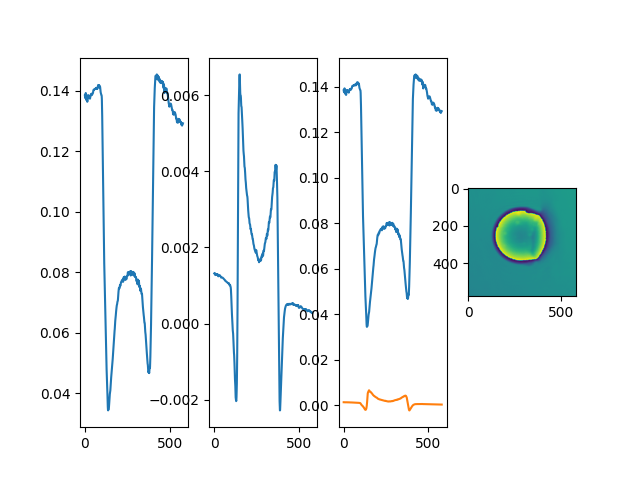

In [12]:
complex_1D = np.sum(complex_obj[0],axis=1)

gradient = np.gradient(complex_1D)
print(gradient.shape)

phase_gradient_y = np.imag( complex_1D.conj() * gradient[0] / np.abs(complex_1D)**2  )

b =  phase_gradient_y
c = 0

# print(a,b,c)

fig, ax = plt.subplots(1,4)
ax[0].plot(complex_1D)
ax[1].plot(b)
ax[2].plot(complex_1D)
ax[2].plot(b)
ax[3].imshow(np.angle(complex_obj[0]))

# plt.figure()
# plt.imshow(frame,cmap='gray',vmax=1)

In [ ]:
# sscCdi.deploy_visualizer(obj,title='Original sinogram',cmap='gray')

In [13]:
crop = np.angle(obj[:,1500:-1400,1400:-1500])
sscCdi.deploy_visualizer(crop,title='Original sinogram',cmap='gray')

## Sort data

In [14]:
sscCdi.tomo_sort(dic,obj, angles)

Time elapsed: 35.56 s


In [15]:
# sscCdi.deploy_visualizer(np.load(dic["ordered_object_filepath"]),title="Ordered sinogram",cmap='gray')

In [16]:
dic["top_crop"]    = 1500
dic["bottom_crop"] = 1400
dic["left_crop"]   = 1400
dic["right_crop"]  = 1500

In [17]:
sscCdi.tomo_crop(dic)

Cropped sinogram shape: (214, 579, 579)
Time elapsed: 36.86 s


In [15]:
sscCdi.deploy_visualizer(np.load(dic["cropped_sinogram_filepath"]),title="Cropped sinogram",cmap='gray')

In [23]:
cropped = np.angle(np.load(dic["cropped_sinogram_filepath"]))
np.save(dic["cropped_sinogram_filepath"],cropped)

TypeError: ufunc 'arctan2' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

## Unwrap

In [19]:
dic["bad_frames_before_unwrap"] = [] #[28,30,45,49,65,66,91,113]

In [20]:
sscCdi.tomo_unwrap(dic)

Using 32 parallel processes


100%|██████████| 214/214 [00:13<00:00, 16.37it/s]


Time elapsed: 21.96 s


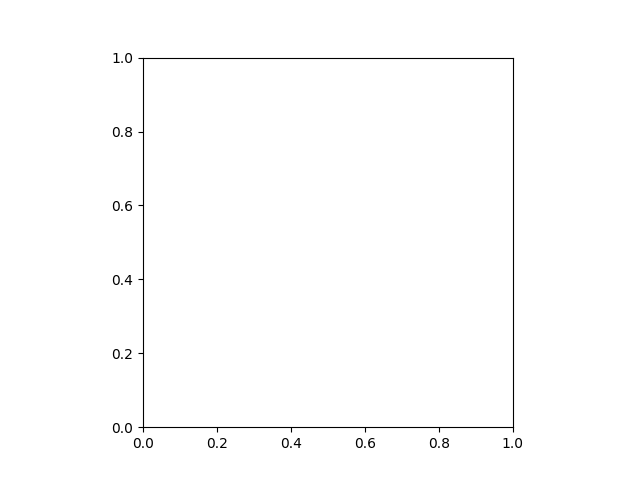

In [21]:
sscCdi.deploy_visualizer(np.load(dic["unwrapped_sinogram_filepath"]),title="Unwrapped sinogram",cmap='gray')

In [8]:
def get_best_plane_fit_inside_mask(mask2,frame ):

    def plane(variables,u,v,a):
        Xmesh,Ymesh = variables
        return np.ravel(u*Xmesh+v*Ymesh+a)

    new   = np.zeros(frame.shape)
    row   = new.shape[0]
    col   = new.shape[1]
    XX,YY = np.meshgrid(np.arange(col),np.arange(row))

    a = b = c = 1e9
    counter = 0
    while np.abs(a) > 1e-8 or np.abs(b) > 1e-8 or counter < 5:
        print(counter,a,b,c)
        print(np.abs(a) > 1e-8,np.abs(b) > 1e-8, counter > 5)
        grad_removed, (a,b,c) = remove_phase_gradient(frame,mask2)
        plane_fit = plane((XX,YY),a,b,c).reshape(XX.shape)
        frame = frame - plane_fit
        counter += 1
    return frame

2.3183799499158847e-21 -7.914458727669376e-21 4.102326214305544e-19


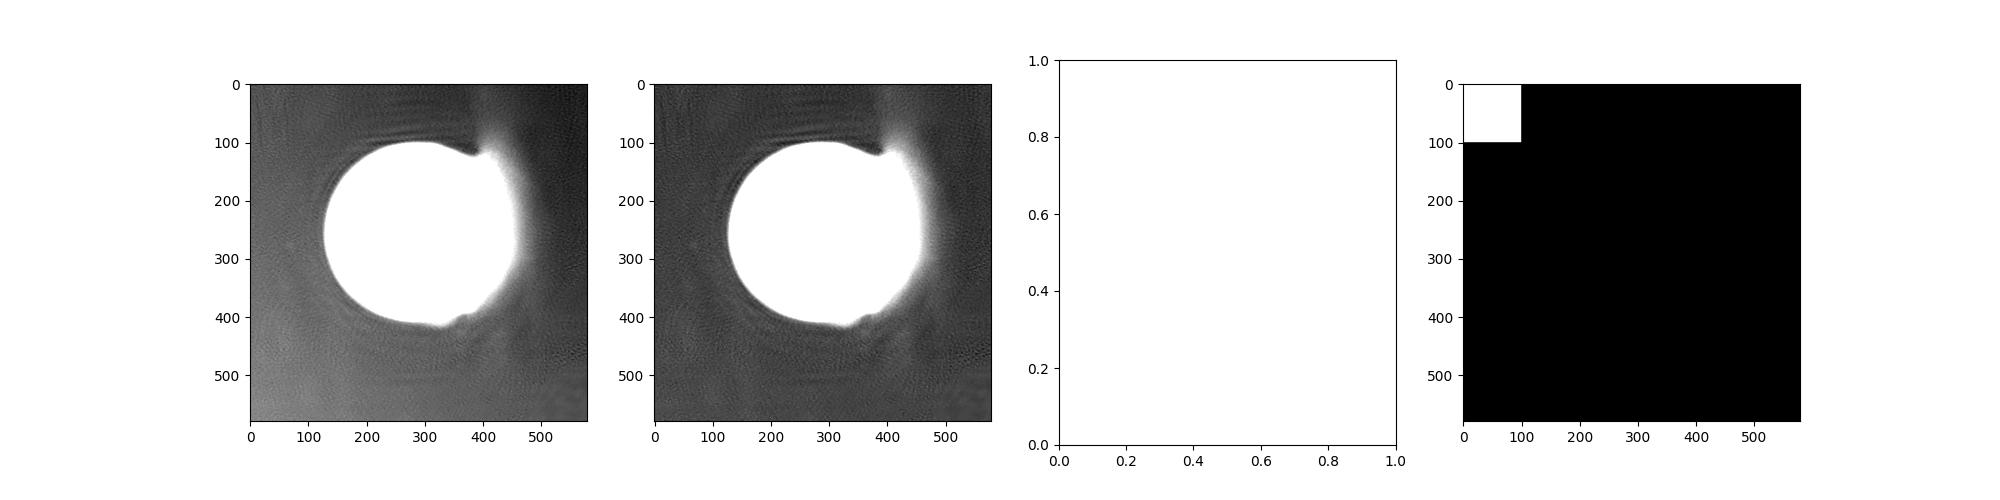

In [12]:
from sscCdi import remove_phase_gradient#, get_best_plane_fit_inside_mask

remove_gradient =     dic["equalize_gradient"] 
    
frame = -np.load(dic["unwrapped_sinogram_filepath"])
frame = frame[21]                 

mask = np.ones_like(frame,dtype=bool)
                 
if remove_gradient[0] == True:
    if remove_gradient[1] == []:
        mask = np.ones_like(frame,dtype=bool)
    else:
        mask = np.zeros_like(frame,dtype=bool)
        mask[remove_gradient[1][0]:remove_gradient[1][1],remove_gradient[1][2]:remove_gradient[1][3]] = True
    frame2, (a,b,c) = remove_phase_gradient(frame, mask)

print(a,b,c)    
    
# mask = np.zeros_like(frame,dtype=bool)
# mask[500:550,0:500] = 1
# mask[0:100,0:100] = 1

# mean = frame*mask
# mean = np.mean(mean[mean>0])
# 
# print(mean)

# frame3, _ = remove_phase_gradient(frame,mask,full=True)
# frame3 = get_best_plane_fit_inside_mask(mask,frame)
# frame4 = frame3 - mean

maximum = 1

N = 15

fig, ax = plt.subplots(1,4,figsize=(20,5))
ax[0].imshow(frame,cmap='gray',vmax=maximum)
ax[1].imshow(frame2,cmap='gray',vmax=maximum)
# ax[2].imshow(frame3,cmap='gray',vmax=maximum)
ax[3].imshow(mask,cmap='gray',vmax=maximum)  


## 2D Equalization

In [8]:
dic["sinogram_to_equalize"] = 'unwrapped' # cropped or unwrapped
dic["bad_frames_before_equalization"] = []
# dic["equalize_gradient"] = [True,[0,100,0,100]]
dic["equalize_gradient"] = [True,[]]
dic["equalize_global_offset"] = False
dic["equalize_invert"] = True
dic["equalize_local_offset"] = [0,100,0,100]
dic["equalize_outliers"] = 0

In [9]:
sscCdi.tomo_equalize(dic)

Sinogram shape to unwrap:  (214, 579, 579)
Using 32 parallel processes


100%|██████████| 214/214 [00:29<00:00,  7.22it/s]


Min 	 Mean-3*sigma 	 Mean 	 Mean+3*sigma 	 Max 
Old  -2.465110023766342 -5.6485345245362755 -0.05861996369783834 5.531294597140599 5.410921937066071
New  -3.6084077 -6.641176462173462 -0.7809006 5.079375267028809 5.707987
Time elapsed: 31.22 s


In [10]:
sscCdi.deploy_visualizer(np.load(dic["equalized_sinogram_filepath"]),title="Equalized sinogram",cmap='gray',axis=1,aspect_ratio='auto',limits=(-1,1))#,limits=(0,0.5))

In [11]:
sscCdi.deploy_visualizer(np.load(dic["equalized_sinogram_filepath"]),title="Equalized sinogram",cmap='gray',axis=1,aspect_ratio='auto',limits=(-3,1))#,limits=(0,0.5))

In [13]:
sscCdi.deploy_visualizer(np.load(dic["equalized_sinogram_filepath"]),title="Equalized sinogram",cmap='gray',axis=1,aspect_ratio='auto',limits=(-1,1))#,limits=(0,0.5))

In [11]:
sscCdi.deploy_visualizer(np.load(dic["equalized_sinogram_filepath"]),title="Equalized sinogram",cmap='gray',axis=1,aspect_ratio='auto',limits=(0,1))#,limits=(0,0.5))

In [12]:
sscCdi.deploy_visualizer(np.load(dic["equalized_sinogram_filepath"]),title="Equalized sinogram",cmap='gray',axis=2,aspect_ratio='auto')#,limits=(0,0.5))

## Alignment

In [23]:
dic["wiggle_sinogram_selection"] = dic["equalized_sinogram_filepath"]
dic["step_percentage"] = 0 # need to project irregular angle steps to a regular grid?

In [24]:
sscCdi.preview_angle_projection(dic)

Simulating projection of angles to regular grid...
Before+after frames added: 59
Intermediate null frames : 105
                        + -----
Total null frames        : 164
Frames being used        : 214  of  214
                        + -----
Projected Angles         : 378


In [25]:
dic["CPUs"] = 64
dic["project_angles_to_regular_grid"] = True
dic["bad_frames_before_wiggle"] = [] 
dic["wiggle_reference_frame"] = 0

In [26]:
dic = sscCdi.tomo_alignment(dic)

ssc-radon: creating 378x579x579 shared arrays (tomogram)
ssc-radon: creating 378x579x579 shared arrays (tomogram)
	Finished vertical wiggle. Starting horizontal wiggle...
ssc-radon: creating 378x579x579 shared arrays (tomogram)
Time elapsed: 8.52 s


In [32]:
sscCdi.deploy_visualizer(np.load(dic["wiggle_sinogram_filepath"]),title="Aligned sinogram",cmap='gray',axis=1,limits=(1,0))

In [29]:
sscCdi.deploy_visualizer(np.load(dic["wiggle_sinogram_filepath"]),title="Aligned sinogram",cmap='gray',axis=2)

## Tomography: select dictionary according to tomographic method!

In [ ]:
# for details on the inputs, see documentation at https://gcc.lnls.br/wiki/docs/ssc-raft/reconstructions/

dic['automatic_regularization'] = 0 # skip if 0; regularization between 0 and 1 to enhance borders prior to recon (https://www.sciencedirect.com/science/article/pii/S2590037419300883?via%3Dihub)

dic["algorithm_dic"] = { # if FBP: filtered back-projection
    'algorithm': "FBP",
    'gpu': [0,1],
    'filter': 'lorentz', # 'gaussian','lorentz','cosine','rectangle'
    'regularization': 0.1, # 0 <= regularization <= 1; use for smoothening
}

# dic["algorithm_dic"] = { # if eEM: emission expectation maximization
#     'algorithm': "EM",
#     'gpu': [0,1],
#     'regularization': 0.0001,
#     'method': 'eEM', 
#     'niterations': [20,0,0,0], # [global iterations, iterations EMTV, iterations2 EMTV, Cone-beam integration points]
#     'epsilon': 1e-15, #for EMTV only
#     'blocksize': 20, # blocks for parallelization
# }

In [ ]:
recon3D = sscCdi.tomo_recon(dic)

In [ ]:
sscCdi.deploy_visualizer(np.load(dic["reconstruction_filepath"]),title="Recon",cmap='gray',axis=0)#,limits=(-1,1))

## 3D Equalization

In [ ]:
dic["tomo_remove_outliers"] = 0
dic["tomo_threshold"] = 15.0
dic["tomo_local_offset"] = []
dic["tomo_mask"] = []

In [ ]:
sscCdi.tomo_equalize3D(dic)

In [ ]:
sscCdi.deploy_visualizer(np.load(dic["eq_reconstruction_filepath"]),title="Equalized Recon",cmap='gray',axis=0)

In [ ]:
equalized_tomogram = np.load(dic["eq_reconstruction_filepath"])
sscCdi.plot_histograms(recon3D, equalized_tomogram,bins=300)